In [1]:
import torch
import matplotlib.pyplot as plt
import copy
from utils import interpolate1d, kld_annealing_beta, replace_upconv, add_noise
from trainer_vae import TrainerVAE
from trainer_dip import TrainerDIP
from trainer_pair import TrainerPair
from models import UNet, VAE, Discriminator
from monai.losses.ssim_loss import SSIMLoss

In [2]:
SIZE = 34 
STD = 0.05
SEED = 999
CHANNELS = [32, 64, 128, 128, 128]
ACT = ("LeakyReLU", {"negative_slope": 0.2})
NSTEPS = 400
SHOW_EVERY = 10
LR = 1e-3

# VAE 
LATENT_CHANNELS = 4
BETA_MAX = 10
BETA_ANNEALING_STEPS = 100

# DIP
NOISE_REG_STD = 0.1

# one from the other
SIM_WEIGHT = 0.5

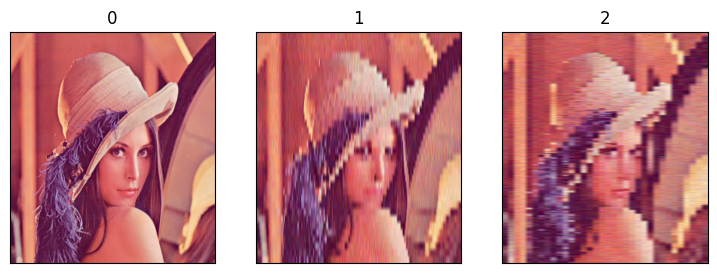

In [3]:
torch.manual_seed(999)

img_0 = torch.from_numpy(plt.imread("Lenna_(test_image).png")).permute(2, 0, 1) 
img_1 = interpolate1d(add_noise(img_0, STD), size=SIZE, dim=1).clip(0, 1)
img_2 = interpolate1d(add_noise(img_0, STD), size=SIZE, dim=2).clip(0, 1)

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1), plt.imshow(img_0.permute(1, 2, 0), aspect="auto"), plt.title("0"), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 2), plt.imshow(img_1.permute(1, 2, 0), aspect="auto"), plt.title("1"), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 3), plt.imshow(img_2.permute(1, 2, 0), aspect="auto"), plt.title("2"), plt.xticks([]), plt.yticks([])
plt.show()

mean = (img_1.mean() + img_2.mean()) / 2
std = (img_1.std() + img_2.std()) / 2
img_0, img_1, img_2 = map(lambda img : (img - mean) / std, [img_0, img_1, img_2]) 

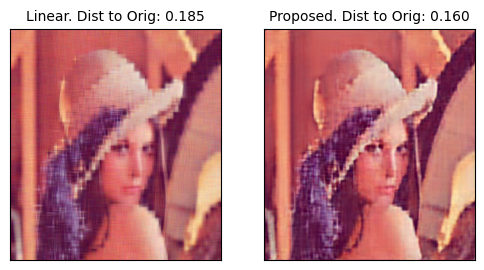

rec = 0.159, kld = 1.779: 100%|██████████| 400/400 [00:26<00:00, 14.94it/s]


In [4]:
# VAE 1: Nearest Upsampling, L1-Loss

vae = VAE(
    spatial_dims = 2,
    in_channels = 3, 
    out_channels = 3, 
    latent_channels = LATENT_CHANNELS,
    channels = CHANNELS, 
    strides = [2] * len(CHANNELS), 
    num_res_units = 0,
    act = ACT,
)
replace_upconv(vae)
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)
if BETA_ANNEALING_STEPS:
    beta = lambda step : kld_annealing_beta(step, BETA_ANNEALING_STEPS, eps=0) * BETA_MAX 
else:
    beta = BETA_MAX
trainer = TrainerVAE(vae, optimizer, beta, img_1, img_2, img_0, NSTEPS, SHOW_EVERY, device="mps")
trainer.train()

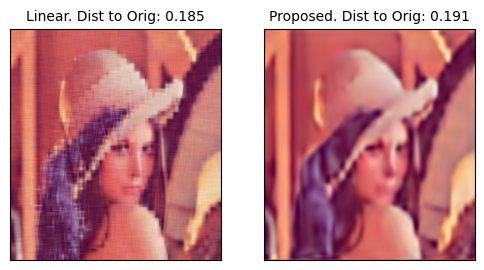

rec = 0.511, kld = 1.956: 100%|██████████| 400/400 [00:37<00:00, 10.72it/s]


In [5]:
# VAE 2: Bilinear Upsampling, SSIM-Loss

vae = VAE(
    spatial_dims = 2,
    in_channels = 3, 
    out_channels = 3, 
    latent_channels = LATENT_CHANNELS,
    channels = CHANNELS, 
    strides = [2] * len(CHANNELS), 
    num_res_units = 0,
    act = ACT,
)
replace_upconv(vae, mode="bilinear")
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)
if BETA_ANNEALING_STEPS:
    beta = lambda step : kld_annealing_beta(step, BETA_ANNEALING_STEPS, eps=0) * BETA_MAX 
else:
    beta = BETA_MAX
trainer = TrainerVAE(vae, optimizer, beta, img_1, img_2, img_0, NSTEPS, SHOW_EVERY, device="mps")
ssim_loss = SSIMLoss(spatial_dims=2, data_range=trainer.inputs.max()-trainer.inputs.min())
def rec_loss(self, rec): return ssim_loss(rec, self.inputs)
trainer.rec_loss = rec_loss.__get__(trainer, TrainerVAE)
trainer.train()

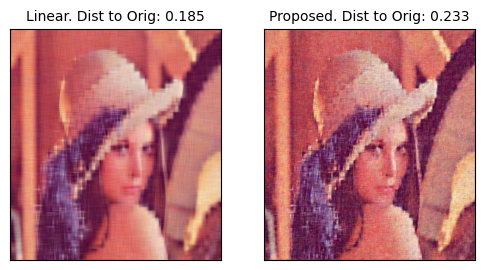

rec = 0.062: 100%|██████████| 400/400 [00:25<00:00, 15.40it/s]


In [6]:
# DIP: Nearest Upsampling
net = UNet(
    spatial_dims = 2, 
    in_channels = 3, 
    out_channels = 3, 
    channels = CHANNELS, 
    strides = [2] * (len(CHANNELS) - 1), 
    num_res_units = 0,
    act = ACT,
)
replace_upconv(net)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
trainer = TrainerDIP(net, optimizer, NOISE_REG_STD, img_1, img_2, img_0, NSTEPS, SHOW_EVERY, device="mps")
trainer.train()

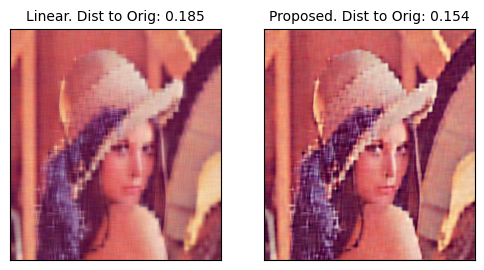

rec_1 = 0.120, rec_2 = 0.114, sim = 0.062: 100%|██████████| 400/400 [00:38<00:00, 10.35it/s]


In [7]:
# one from the other: Nearest Upsampling
net_1 = UNet(
    spatial_dims = 2, 
    in_channels = 3, 
    out_channels = 3, 
    channels = CHANNELS, 
    strides = [2] * (len(CHANNELS) - 1), 
    num_res_units = 0,
    act = ACT,
)
replace_upconv(net_1)
net_2 = copy.deepcopy(net_1)
optimizer = torch.optim.Adam(list(net_1.parameters()) + list(net_2.parameters()), lr=LR)
sim_weight = SIM_WEIGHT
trainer = TrainerPair(net_1, net_2, optimizer, SIM_WEIGHT, img_1, img_2, img_0, NSTEPS, SHOW_EVERY, device="mps")
trainer.train()